# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/[2024-2025] AN2DL HW2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1z5t8kqLSNnsGWmeDMitEc48VDF9xBUOx/[2024-2025] AN2DL HW2


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## Split

In [ ]:
# Load the cleaned dataset
data = np.load("mars_cleaned_dataset.npz")
X = data["X_train"]
y = data["y_train"]

# Split
test_size = 0.15
adjusted_val_size = 0.176
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=adjusted_val_size, random_state=seed
)

# Turning np dataset in tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch the datasets
BATCH_SIZE = 8
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)

# Optionally, you can shuffle and prefetch for performance optimization
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

# Print out the number of batches in each dataset (after batching)
print(f"\nNumber of batches:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")


Number of batches:
Train: 220
Validation: 47
Test: 47


## Class Weights

In [ ]:
# Define class labels for better readability
class_labels = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

# Ensure input is a 1D array of integers
y_vector = np.ravel(y_train).astype(int)

# Calculate class counts
class_counts = np.bincount(y_vector, minlength=len(class_labels))

# Calculate frequency percentages
class_frequencies = class_counts / np.sum(class_counts) * 100

# Display class counts and percentages
print("Class Distribution:\n")
for i, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
    print(f"Class {i} ({class_labels[i]}):")
    print(f"    Pixels: {count}")
    print(f"    Frequency: {freq:.2f}%")

# Calculate raw weights as the inverse of the frequencies
raw_weights = {cls: 1.0 / freq for cls, freq in zip(range(len(class_frequencies)), class_frequencies)}

# Normalize the weights so that their sum equals the number of classes
sum_of_raw_weights = sum(raw_weights.values())
num_classes = len(class_labels)

normalized_weights = {cls: (weight / sum_of_raw_weights) * num_classes for cls, weight in raw_weights.items()}

# Display results
print("Class Frequencies:", class_frequencies)
print("Raw Weights:", raw_weights)
print("Normalized Weights:", normalized_weights)

Class Distribution:

Class 0 (Background):
    Pixels: 3512496
    Frequency: 24.45%
Class 1 (Soil):
    Pixels: 4863886
    Frequency: 33.85%
Class 2 (Bedrock):
    Pixels: 3498998
    Frequency: 24.35%
Class 3 (Sand):
    Pixels: 2473313
    Frequency: 17.21%
Class 4 (Big Rock):
    Pixels: 20075
    Frequency: 0.14%
Class Frequencies: [24.44535259 33.85040388 24.35141273 17.21311806  0.13971274]
Raw Weights: {0: 0.04090757114029454, 1: 0.029541745016227763, 2: 0.0410653792885849, 3: 0.05809522692841545, 4: 7.157543212951432}
Normalized Weights: {0: 0.027915051306267202, 1: 0.02015908803229728, 2: 0.02802273852487435, 3: 0.0396437919717635, 4: 4.884259330164797}


## Functions

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
from matplotlib.colors import ListedColormap

# Define class labels and colormap
CLASS_LABELS = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
COLORS = ["black", "brown", "gray", "yellow", "darkred"]
cmap = ListedColormap(COLORS)

def plot_triptychs(dataset, model, num_samples=1, seed=42):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    seed: int - Random seed for shuffling the dataset
    """
    # Shuffle the dataset and then take `num_samples` random samples
    shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    samples = shuffled_dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0], cmap='gray')  # Assuming grayscale images
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        axes[1].imshow(labels[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        im = axes[2].imshow(pred[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[2].axis('off')

        # Add a color legend for the segmentation classes
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.022, pad=0.04)
        cbar.set_ticks(range(len(CLASS_LABELS)))
        cbar.set_ticklabels([CLASS_LABELS[i] for i in range(len(CLASS_LABELS))])

        plt.tight_layout()
        plt.show()
        plt.close()

In [ ]:
def contains_big_rock(images, label):
    """
    Check if the label contains the undersampled class 'Big Rock' (class label 4).

    Parameters:
    label: tf.Tensor - The label tensor

    Returns:
    bool - True if the label contains 'Big Rock', otherwise False
    """
    return tf.reduce_any(label == 4)

# Filter the test dataset to include only samples containing 'Big Rock'
filtered_test_dataset = test_dataset.unbatch().filter(lambda image, label: contains_big_rock(image, label)).batch(64)

In [ ]:
def plot_history(history, loss_fn_name):
    """
    Plots training and validation loss, accuracy, and mean IoU from the training history.

    Parameters:
    history (dict): The training history containing 'loss', 'val_loss', 'accuracy', 'val_accuracy',
                    'mean_iou', and 'val_mean_iou'.
    loss_fn_name (str): The name of the loss function used in the training (e.g., 'Focal Loss').
    """
    metrics = {
        "Loss (" + loss_fn_name + ")": ("loss", "val_loss"),
        "Accuracy": ("accuracy", "val_accuracy"),
        "Mean Intersection Over Union": ("mean_iou", "val_mean_iou")
    }

    # Plot the metrics
    for title, (train_key, val_key) in metrics.items():
        plt.figure(figsize=(10, 4))
        plt.plot(history[train_key], label='Training', alpha=0.8, linewidth=2)
        plt.plot(history[val_key], label='Validation', alpha=0.9, linewidth=2)
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel(title.split(" ")[0])
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def plot_results(model, dataset, num_samples=3, seed=42):
    """
    Plots triptychs of original images, true masks, and predicted masks.

    Parameters:
    - model: tf.keras.Model - The trained model used for predictions.
    - dataset: tf.data.Dataset - The dataset to sample from.
    - num_samples: int - Number of samples to visualize.
    - seed: int - Random seed for reproducibility.
    """

    # Set the random seed for reproducibility
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Unbatch and shuffle the dataset
    dataset = dataset.unbatch().shuffle(buffer_size=1000, seed=seed)
    samples = dataset.take(num_samples)

    # Assuming the model predicts segmentation masks with a shape (height, width, num_classes)
    # We'll convert predictions to argmax class indices
    for image, true_mask in samples:
        # Add batch dimension
        image_batch = tf.expand_dims(image, axis=0)

        # Predict the mask
        pred_mask = model.predict(image_batch, verbose=0)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = tf.squeeze(pred_mask, axis=0).numpy()

        # Convert image and true_mask to numpy arrays for plotting
        image = image.numpy()
        true_mask = true_mask.numpy()

        # Define the number of classes from model output
        num_classes = model.output_shape[-1]

        # Define a colormap for visualization
        cmap = plt.get_cmap('tab20', num_classes)

        # Plot the triptych: original image, true mask, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        # If image is single-channel, display as grayscale
        if image.ndim == 3 and image.shape[-1] == 1:
            axes[0].imshow(image[..., 0], cmap='gray')
        else:
            axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # True mask
        axes[1].imshow(true_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[1].set_title('True Mask')
        axes[1].axis('off')

        # Predicted mask
        axes[2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=num_classes-1)
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()


## Modify the Training Function
Update your train function to accept an optional model_name parameter for better tracking:



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import json
import datetime

# Parameters
INPUT_SHAPE = (64, 128, 1)
NUM_CLASSES = 5
LEARNING_RATE = 1e-4
EPOCHS = 150
PATIENCE = 5

# Callbacks
lr_reduction = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=PATIENCE,
    min_lr=1e-6,
    factor=0.2,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=EPOCHS,
    restore_best_weights=True
)
callbacks = [lr_reduction, early_stopping]

###Train Func

In [ ]:
import os
import datetime
import json

def train(loss_fn, train_dataset, val_dataset, model_name='UNet'):
    global LEARNING_RATE, EPOCHS, NUM_CLASSES, callbacks

    # Create the model
    model = unet()

    # Compile the model
    model.compile(
        loss=loss_fn,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    ).history

    # Calculate the final validation MeanIoU
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

    # Create a timestamp for unique file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Define a directory to store models and histories
    save_dir = 'Oversampling'
    os.makedirs(save_dir, exist_ok=True)

    # Save the model with the accuracy in the filename inside the specified directory
    model_filename = os.path.join(save_dir, f'{model_name}_{loss_fn.__class__.__name__}_{final_val_meanIoU}_{timestamp}.keras')
    model.save(model_filename)
    print(f'Model saved as {model_filename}')

    # Save training history as a JSON file inside the same directory
    history_filename = os.path.join(save_dir, f"history_{model_name}_{loss_fn.__class__.__name__}_{timestamp}.json")
    with open(history_filename, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved as {history_filename}")

    # Delete the model to free up resources
    del model

    # Return the history dictionary
    return history, model_filename


# Data Sampling Techniques

## Oversampling

In [ ]:

def contains_big_rock(images, label):
    return tf.reduce_any(label == 4)

# Split the training dataset into 'big_rock' and 'non_big_rock' subsets
big_rock_dataset = train_dataset.unbatch().filter(lambda x, y: contains_big_rock(x, y)).batch(BATCH_SIZE)
non_big_rock_dataset = train_dataset.unbatch().filter(lambda x, y: tf.logical_not(contains_big_rock(x, y))).batch(BATCH_SIZE)

# Define an oversampling factor
oversampling_factor = 3  # Try different values to see the effect

# Repeat the big_rock_dataset multiple times to oversample
oversampled_big_rock_dataset = big_rock_dataset.repeat(oversampling_factor)

# Combine back the oversampled big rock samples with the non-big rock samples
oversampled_train_dataset = non_big_rock_dataset.concatenate(oversampled_big_rock_dataset)
oversampled_train_dataset = oversampled_train_dataset.shuffle(buffer_size=1000, seed=seed).prefetch(tf.data.AUTOTUNE)


###Train without OS

In [ ]:

##########################################
# Train & Evaluate WITHOUT Oversampling
##########################################
loss = tf.keras.losses.SparseCategoricalCrossentropy()
history_no_oversampling, model_filename= train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset)


Epoch 1/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.3383 - loss: 1.6358 - mean_iou: 0.1019 - val_accuracy: 0.4862 - val_loss: 1.3243 - val_mean_iou: 0.2281 - learning_rate: 1.0000e-04
Epoch 2/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5139 - loss: 1.2284 - mean_iou: 0.2564 - val_accuracy: 0.6161 - val_loss: 1.0145 - val_mean_iou: 0.3301 - learning_rate: 1.0000e-04
Epoch 3/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5654 - loss: 1.0971 - mean_iou: 0.3025 - val_accuracy: 0.6455 - val_loss: 0.9538 - val_mean_iou: 0.3574 - learning_rate: 1.0000e-04
Epoch 4/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5902 - loss: 1.0496 - mean_iou: 0.3213 - val_accuracy: 0.6671 - val_loss: 0.8860 - val_mean_iou: 0.3719 - learning_rate: 1.0000e-04
Epoch 5/150
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6040 - loss: 1.0119 - mean_iou: 0.3284 - val_accuracy: 0.6512 - val_loss: 0.8943 - val_mean_iou: 0.3681 - learning_rate: 1.0000e-04

In [ ]:

# Load the best model saved during training without oversampling
# (This step may vary depending on how you save and name your models)
model_no_oversampling = tfk.models.load_model(model_filename, compile=False)

model_no_oversampling.compile(
    loss=loss,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

test_loss_no_over, test_acc_no_over, test_miou_no_over = model_no_oversampling.evaluate(test_dataset, verbose=0, batch_size=10)
y_true_list = []
y_pred_list = []

for images, labels in test_dataset:
    preds = model_no_oversampling.predict(images, verbose=0)
    preds = np.argmax(preds, axis=-1)
    y_true_list.extend(labels.numpy().reshape(-1))
    y_pred_list.extend(preds.reshape(-1))

# Filter out background class (0) from evaluation if desired
mask = (np.array(y_true_list) != 0)
y_true_filtered = np.array(y_true_list)[mask]
y_pred_filtered = np.array(y_pred_list)[mask]

precision_no_over = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
recall_no_over = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
f1_no_over = f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)


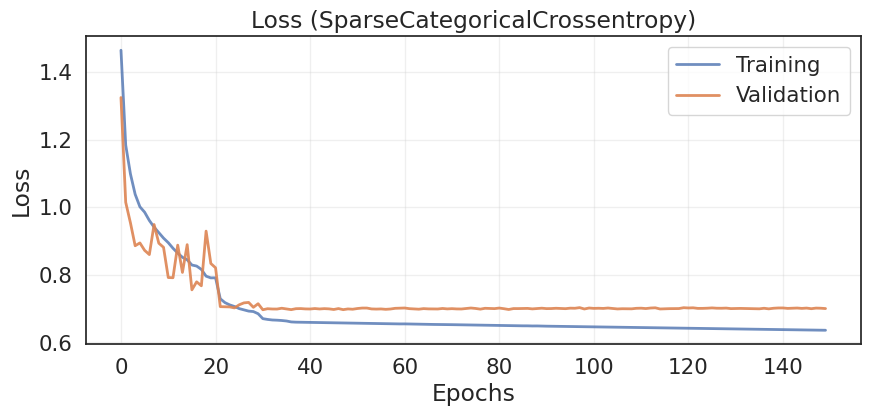

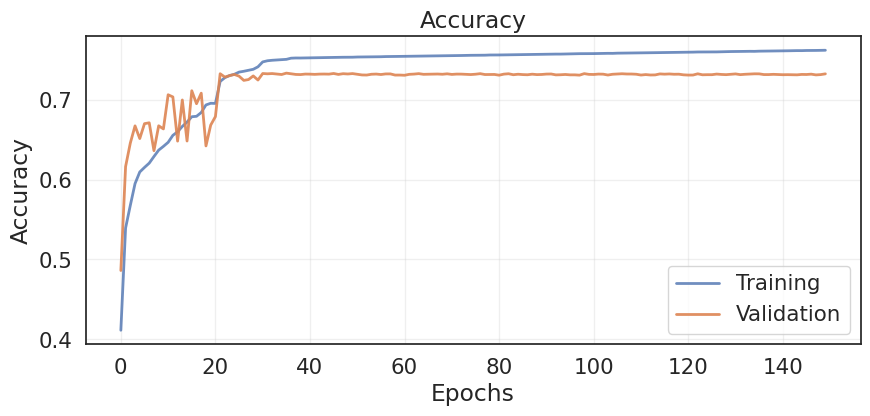

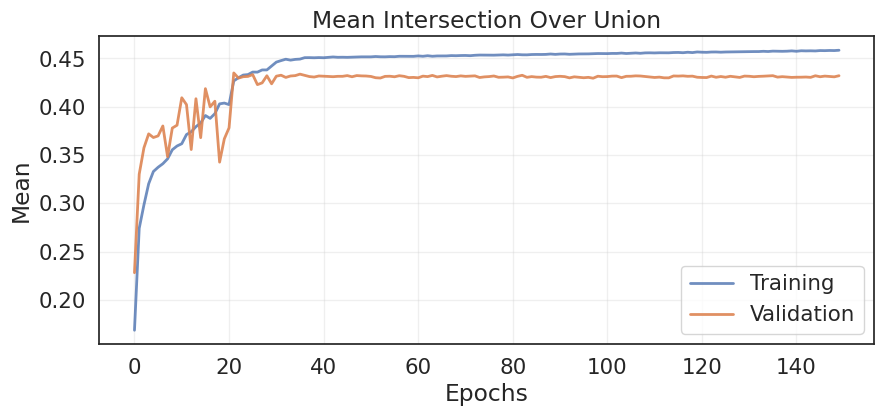

In [ ]:
plot_history(history_no_oversampling, "SparseCategoricalCrossentropy")  # or whichever loss name


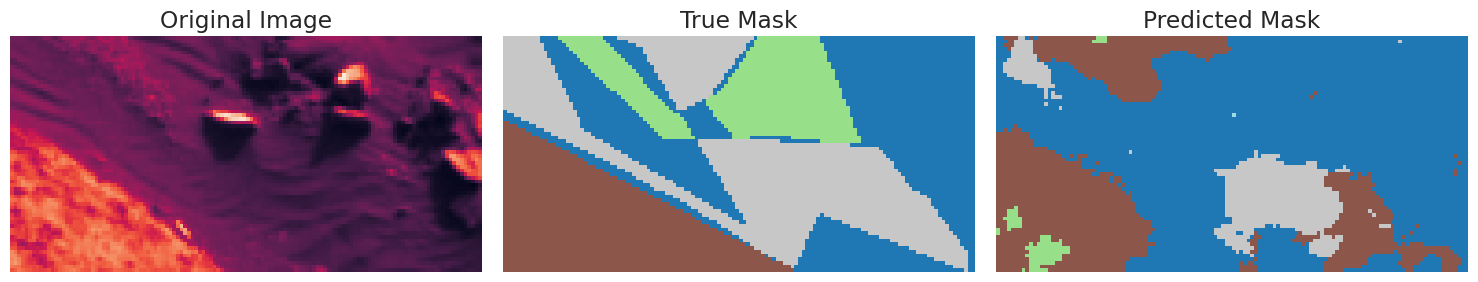

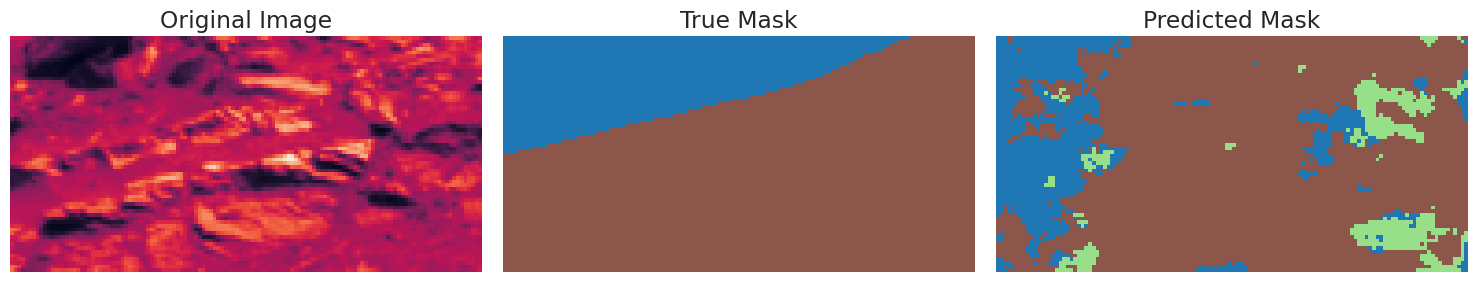

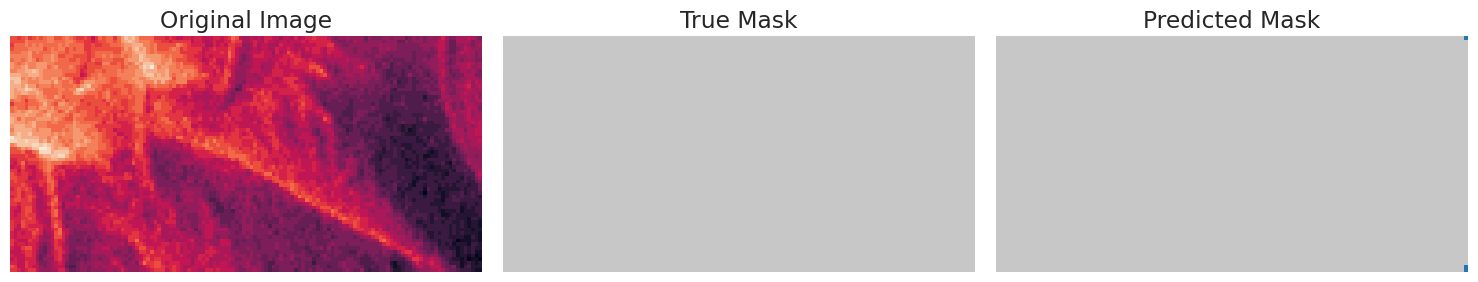

In [ ]:
plot_results(model_no_oversampling, test_dataset, num_samples=3, seed=42)


### Train with OS

In [ ]:

##########################################
# Train & Evaluate WITH Oversampling
##########################################
loss = tf.keras.losses.SparseCategoricalCrossentropy()
history_with_oversampling, model_filename = train(loss_fn=loss,
                                                  train_dataset=oversampled_train_dataset,
                                                  val_dataset=val_dataset)


Epoch 1/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.3740 - loss: 1.5596 - mean_iou: 0.1516 - val_accuracy: 0.5405 - val_loss: 1.1948 - val_mean_iou: 0.2779 - learning_rate: 1.0000e-04
Epoch 2/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5334 - loss: 1.2013 - mean_iou: 0.2738 - val_accuracy: 0.5937 - val_loss: 1.1087 - val_mean_iou: 0.3076 - learning_rate: 1.0000e-04
Epoch 3/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5736 - loss: 1.1088 - mean_iou: 0.3027 - val_accuracy: 0.6187 - val_loss: 0.9982 - val_mean_iou: 0.3320 - learning_rate: 1.0000e-04
Epoch 4/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5882 - loss: 1.0570 - mean_iou: 0.3203 - val_accuracy: 0.5992 - val_loss: 1.0354 - val_mean_iou: 0.3092 - learning_rate: 1.0000e-04
Epoch 5/150
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5965 - loss: 1.0306 - mean_iou: 0.3307 - val_accuracy: 0.6791 - val_loss: 0.9007 - val_mean_iou: 0.3875 - learning_rate: 1.0000e-04

In [ ]:

# Load the best model saved during training with oversampling
model_with_oversampling = tfk.models.load_model(model_filename, compile=False)
model_with_oversampling.compile(
    loss=loss,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

test_loss_over, test_acc_over, test_miou_over = model_with_oversampling.evaluate(test_dataset, verbose=0, batch_size=10)
y_true_list_over = []
y_pred_list_over = []

for images, labels in test_dataset:
    preds = model_with_oversampling.predict(images, verbose=0)
    preds = np.argmax(preds, axis=-1)
    y_true_list_over.extend(labels.numpy().reshape(-1))
    y_pred_list_over.extend(preds.reshape(-1))

# Filter out background class (0) if desired
mask_over = (np.array(y_true_list_over) != 0)
y_true_filtered_over = np.array(y_true_list_over)[mask_over]
y_pred_filtered_over = np.array(y_pred_list_over)[mask_over]

precision_over = precision_score(y_true_filtered_over, y_pred_filtered_over, average='macro', zero_division=0)
recall_over = recall_score(y_true_filtered_over, y_pred_filtered_over, average='macro', zero_division=0)
f1_over = f1_score(y_true_filtered_over, y_pred_filtered_over, average='macro', zero_division=0)


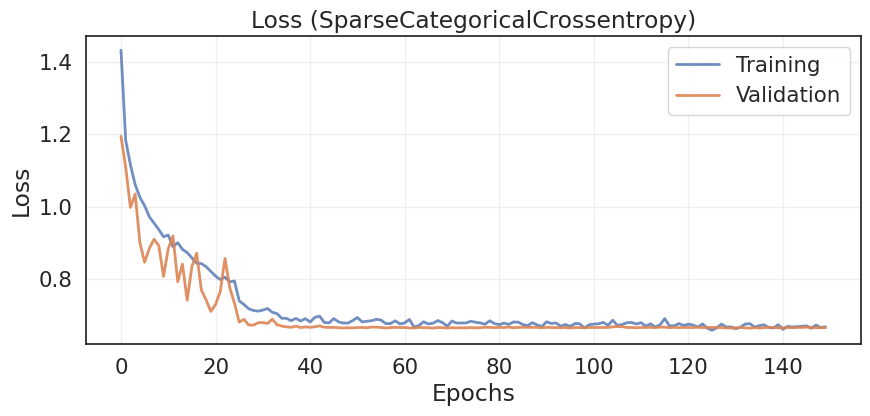

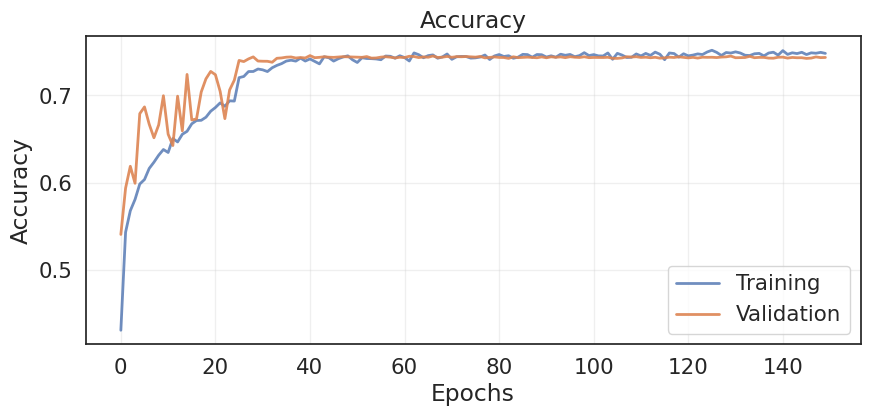

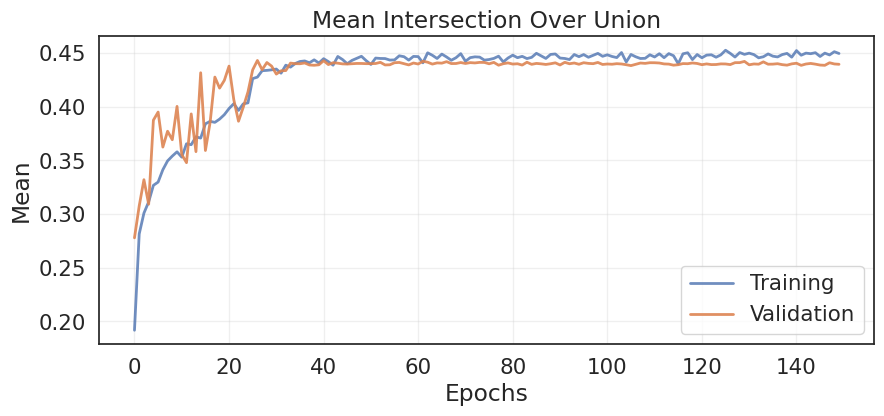

In [ ]:
plot_history(history_with_oversampling, "SparseCategoricalCrossentropy")  # or whichever loss name


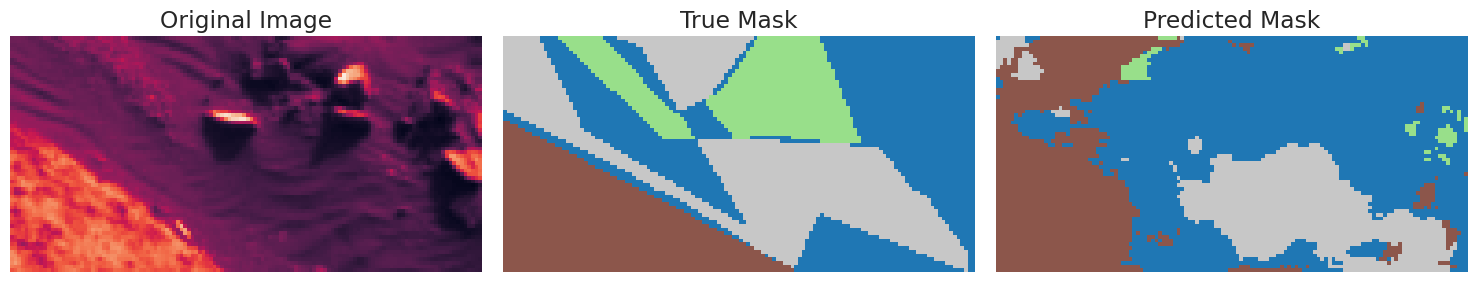

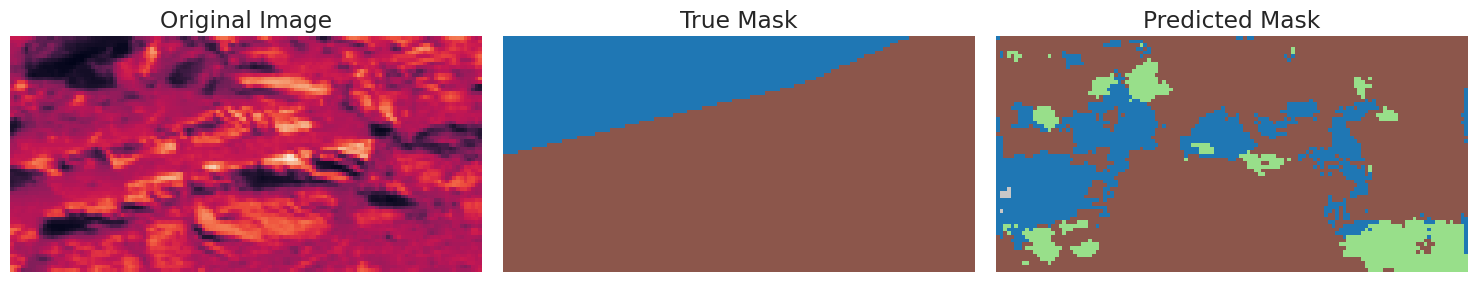

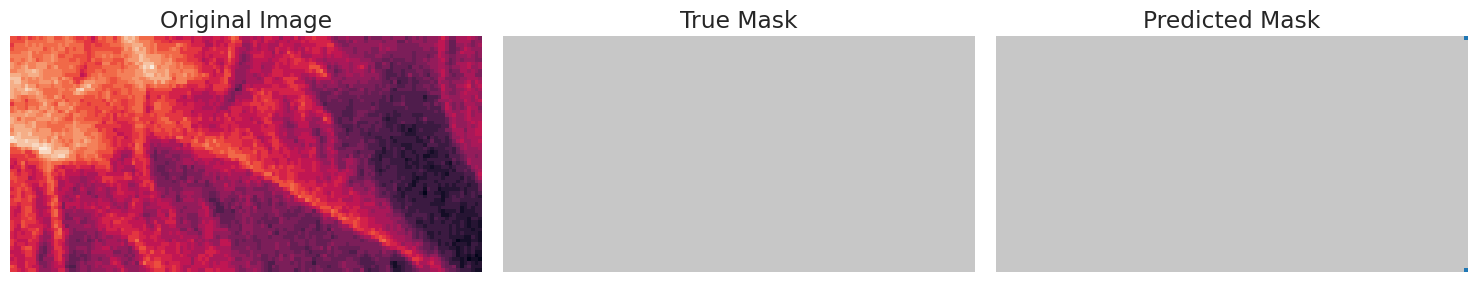

In [ ]:
plot_results(model_with_oversampling, test_dataset, num_samples=3, seed=42)


In [ ]:

##########################################
# Display Results in a Table
##########################################

import pandas as pd

results_df = pd.DataFrame({
    'Setup': ['Without Oversampling', 'With Oversampling'],
    'Test Loss': [test_loss_no_over, test_loss_over],
    'Test Accuracy': [test_acc_no_over, test_acc_over],
    'Test Mean IoU': [test_miou_no_over, test_miou_over],
    'Precision': [precision_no_over, precision_over],
    'Recall': [recall_no_over, recall_over],
    'F1-Score': [f1_no_over, f1_over]
})

print(results_df.to_string(index=False))


               Setup  Test Loss  Test Accuracy  Test Mean IoU  Precision   Recall  F1-Score
Without Oversampling   0.760274       0.715559       0.417591   0.518774 0.466799  0.491394
   With Oversampling   0.709043       0.736233       0.435093   0.531211 0.478401  0.503334
